## Load The Data

In [14]:
import spacy
nlp = spacy.load('pl_core_news_sm')

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

df = pd.read_csv("colocates.csv", parse_dates= ['date'])
#df.colocate = df.colocate.apply(lambda colocate: " ".join([token.lemma_ for token in nlp(colocate)]) )
df.head()

,text_id,date,source,colocate,id
0,111,2021-02-21,DoRzeczy,twierdzą niezbędne żeby przeciwstawić się zmi...,0
1,156,2021-02-28,DoRzeczy,fałszywy alarm jak panika wokół zmiany klimatu...,1
2,156,2021-02-28,DoRzeczy,klimatyści tak jak model kosztów zmian klimaty...,2
3,156,2021-02-28,DoRzeczy,2030 r aby rozwiązać problem zmian klimatyczn...,3
4,156,2021-02-28,DoRzeczy,trzeba by zrobić żeby utrzymać zmiany klimatyc...,4


In [2]:
df['word'] = df.colocate.str.split(" ")
df = df.explode('word')
df.drop('colocate', inplace=True, axis=1)
df.head()

,text_id,date,source,id,word
0,111,2021-02-21,DoRzeczy,0,twierdzą
0,111,2021-02-21,DoRzeczy,0,
0,111,2021-02-21,DoRzeczy,0,niezbędne
0,111,2021-02-21,DoRzeczy,0,żeby
0,111,2021-02-21,DoRzeczy,0,przeciwstawić


In [3]:
window_width = 6 * 30 # 6 months
time_step = 3 * 30 # 3 months

start_date = df.date.min()
end_date = start_date + datetime.timedelta(days=window_width)
max_date = df.date.max()

df['window_group'] = None
index = 0
dates = []
while start_date < max_date:
    df.loc[df.date.between(start_date, end_date), 'window_group'] = index
    end_date += datetime.timedelta(days=time_step)
    start_date += datetime.timedelta(days=time_step)
    dates.append(start_date + datetime.timedelta(days=window_width/2))
    index += 1
    
print(f"{index + 1} windows created")

34 windows created


In [4]:
n_words =len(df['word'].unique())
print(f"Number of unique words: {n_words}")

Number of unique words: 15492


# Vector

Text(0, 0.5, 'Number of nodes')

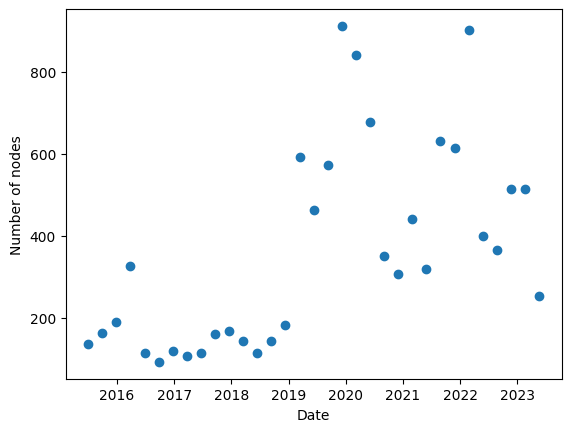

In [5]:
window_nodes_count = df.groupby('window_group').id.unique().apply(len)
plt.scatter(dates, window_nodes_count)
plt.xlabel('Date')
plt.ylabel('Number of nodes')

In [8]:
import seaborn as sns
count_words = df['word'].value_counts()
count_words.describe()

count    15492.000000
mean        10.032791
std        145.404393
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max      12654.000000
Name: word, dtype: float64

Text(0, 0.5, 'Count')

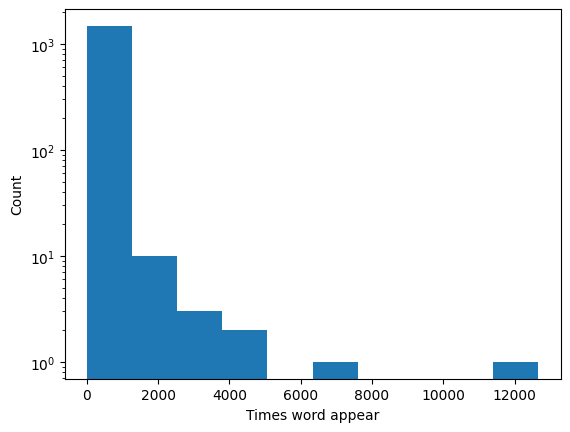

In [26]:
plt.hist(count_words[count_words > 10])
plt.yscale('log')
plt.xlabel('Times word appear')
plt.ylabel('Count')

# Colocates By Score

In [13]:
# Todo: LogDice

In [14]:
#Todo: MI Score

In [ ]:
#Todo: Delta P

# Selected Colocates into Vector

In [27]:
#Todo: decide what does it mean to colocate with the other word
#Frequency treshold with normalization 